# Assignment 6 Math Foundations Machine Learning
## David Alvear 187594

In [64]:
import numpy as np
import pandas as pd
import torch
import scipy
import scipy.linalg
from torch import nn
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from scipy.stats import multivariate_normal
from torch.utils.data import Dataset, random_split, DataLoader

## 1. Verify gradient computation

In [3]:
class model(nn.Module):
    def __init__(self, input=3, output=2):
        super(model, self).__init__() 
        self.h = nn.Sequential(
            nn.Linear(3,2, bias=False),
            nn.ReLU(),
        )
        self.dense = nn.Sequential(
            nn.Linear(2,1, bias=False),
            nn.ReLU()
        )

            # Initialize weights for 'h' layer
        self.h[0].weight.data = torch.tensor([[1.0, 0.0, 1.0], [1.0, -1.0, 0.0]], requires_grad=True)
        
        # Initialize weights for 'dense' layer
        self.dense[0].weight.data = torch.tensor([[0.0, 1.0]], requires_grad=True)
        
        
    def forward(self, x):
        h = self.h(x)
        print(h)
        y = self.dense(h)
        print(y)
        return y
        

In [9]:
mod = model()
optimizer = torch.optim.SGD(mod.parameters(), lr=0.01)
criterion = nn.MSELoss()

input_tensor = torch.tensor([[1.0, 2.0, 1.0]], requires_grad=True)
target_tensor = torch.tensor([[1.0]])

# Forward pass
output_tensor = mod(input_tensor)

# Compute loss
loss = criterion(output_tensor, target_tensor)
print(f'loss: {loss}')

# Zero the gradients
optimizer.zero_grad()

# Backward pass
loss.backward()
# Print gradients
for name, param in mod.named_parameters():
    print(f"Gradient of {name}: {param.grad}")

# Update the weights
optimizer.step()

tensor([[2., 0.]], grad_fn=<ReluBackward0>)
tensor([[0.]], grad_fn=<ReluBackward0>)
loss: 1.0
Gradient of h.0.weight: tensor([[0., 0., 0.],
        [0., 0., 0.]])
Gradient of dense.0.weight: tensor([[0., 0.]])


## 2. House price prediction
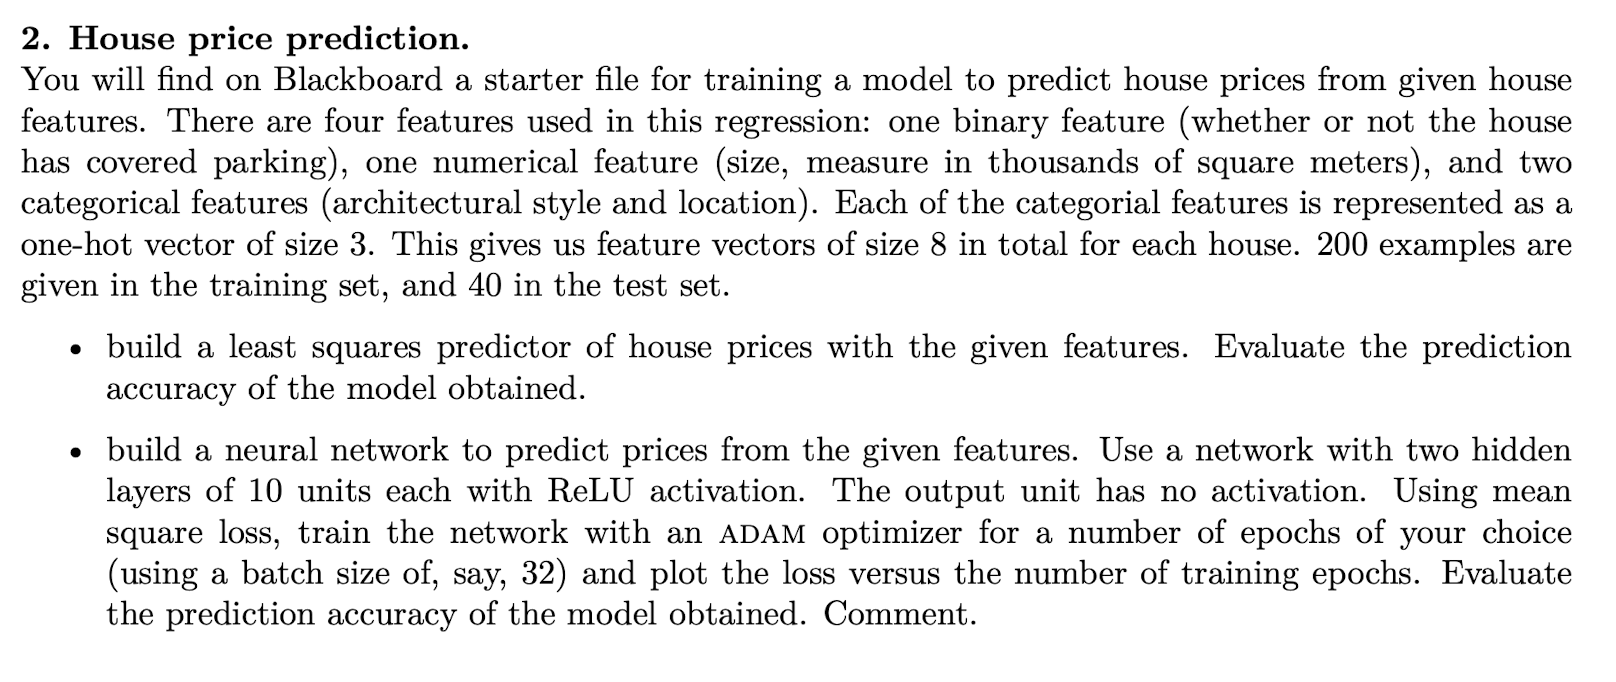

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Read training data
df = pd.read_csv('../data/houses_train.txt', delimiter = "\t", skiprows=[0, 1, 2, 3, 4], header=None) 
X = df.iloc[:, [0,1,2,3,4, 6,7,8]].to_numpy().astype(np.float32)
y = df.iloc[:, 5].to_numpy().astype(np.float32)
N, D = X.shape


# Read testing data
df2 = pd.read_csv('../data/houses_test.txt', delimiter = "\t", header=None) 
X_test = df2.iloc[:, [0,1,2,3,4, 6,7,8]].to_numpy().astype(np.float32)
y_test = df2.iloc[:, 5].to_numpy().astype(np.float32)

In [12]:
df.head()

,0,1,2,3,4,5,6,7,8
0,-1,0.1275,0,1,0,0.300,0,0,1
1,1,0.1100,1,0,0,0.335,1,0,0
2,-1,0.1375,0,0,1,0.286,0,1,0
3,1,0.1975,0,1,0,0.512,0,0,1
4,-1,0.1200,0,0,1,0.295,1,0,0


### Least Squares Predictor

In [21]:
##########################################
############## Regression ########
##########################################

class Regression:
    def __init__(self, x_train, y_train, x_test, y_test):
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test
        self.w_b = None

    def train(self, mode='solve_triangular'):
        n, m = self.x_train.shape
        train = np.hstack([self.x_train, np.ones((self.x_train.shape[0], 1))])
        if mode == 'solve_triangular':
            # QR factorization
            Q, R = scipy.linalg.qr(train)
            Q = Q[:,:m+1]
            R = R[:m+1,:]
            # solve least squares problem
            self.w_b = scipy.linalg.solve_triangular(R, np.dot(Q.T, self.y_train))
        elif mode == 'solve':
            self.w_b = scipy.linalg.solve(np.dot(train.T, train), np.dot(train.T, self.y_train))

    def predict(self, test_data: np.ndarray):
        # predict
        if self.w_b is None:
            return None # not trained yet
        test_data = np.hstack([test_data, np.ones((test_data.shape[0], 1))])
        linear_out = np.dot(test_data, self.w_b)
#         predictions = np.sign(linear_out)
        return linear_out

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [17]:
# Fit the data
ls_model = Regression(X, y, X_test, y_test)
ls_model.train()

In [19]:
# predict
predictions = ls_model.predict(X_test)

In [22]:
# Evaluate
print(f'RMSE: {rmse(predictions, y_test)}')

RMSE: 0.027830121064870744


#### Comments
- The model's predictions are on average 0.02 units off from the ground truth values.
- With the Least Squares model we can create a house price predictor with a decent RMSE error.
- The performance of this model will be compared in base of the rmse calculated.

### FFN Model

In [49]:
class dataset(Dataset):
    def __init__(self, X:torch.tensor, Y:torch.tensor):
        self.X = X
        self.Y = Y
        self.feature_size = self.X.size(1)
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
        
class RegressionModel(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(RegressionModel, self).__init__()
        # two hidden layers of 10 units each
        self.hidden1 = nn.Sequential(
            nn.Linear(in_channels, 10),
            nn.ReLU(inplace=True),
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(10, 10),
            nn.ReLU(inplace=True),
        )
        self.dense = nn.Linear(10, out_channels)

    def forward(self, x):
        latent_x = self.hidden1(x)
        latent_x = self.hidden2(latent_x)
        return self.dense(latent_x)

def one_epoch(model, dataloader, criterion, optimizer=None, training=True):
    """Perform one epoch"""
    total_loss = 0.0
    with torch.set_grad_enabled(training):
        model.train(training)
        for i, (input, targets) in enumerate(dataloader):
            prediction = model(input).squeeze()
            loss = criterion(prediction, targets)
            if training:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            total_loss += loss.item()  # get the scalar value of the loss tensor
    return total_loss / len(dataloader)
    
def train(epochs, model, optimizer, criterion, train_dataloader, eval_dataloader):
    logs = []
    for epoch in range(epochs):
        # Run training 
        train_loss_epoch = one_epoch(
            model,
            train_dataloader,
            criterion,
            optimizer,
            True
        )

        # Run evaluation
        eval_loss_epoch = one_epoch(
            model,
            eval_dataloader,  # Corrected to eval_dataloader
            criterion,
            None,  # No optimizer for evaluation
            False
        )

        logs.append((train_loss_epoch, eval_loss_epoch))
        print(f"Epoch: {epoch}, Training Loss Avg: {train_loss_epoch:.4f}, Test Loss: {eval_loss_epoch:.4f}")
    return logs

##########################################
############## Plot semilog ##############
##########################################
def plot_loss(train_loss, test_loss):
    plt.figure(figsize=(12, 6))
    plt.semilogy(train_loss, label='Training Loss')
    plt.semilogy(test_loss, label='Testing Loss')
    ymin, ymax = plt.ylim()  # Get current y-axis limits
    yticks = np.linspace(ymin, ymax, num=10)  # Create 10 equally spaced ticks
    plt.yticks(yticks)  # Set custom y-ticks
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Convergence')
    plt.legend()
    plt.grid(True)
    plt.show()

In [51]:
# generate dataset
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

train_dataset = dataset(X, y)
test_dataset = dataset(X_test, y_test)
# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [58]:
reg_model = RegressionModel(train_dataset.feature_size, 1)
optimizer = torch.optim.Adam(reg_model.parameters(), lr=0.05)
criterion = nn.MSELoss()
# train the model
logs = train(50, reg_model, optimizer, criterion, train_dataloader, test_dataloader)

Epoch: 0, Training Loss Avg: 0.1835, Test Loss: 0.0361
Epoch: 1, Training Loss Avg: 0.0413, Test Loss: 0.0323
Epoch: 2, Training Loss Avg: 0.0264, Test Loss: 0.0204
Epoch: 3, Training Loss Avg: 0.0184, Test Loss: 0.0257
Epoch: 4, Training Loss Avg: 0.0153, Test Loss: 0.0208
Epoch: 5, Training Loss Avg: 0.0156, Test Loss: 0.0158
Epoch: 6, Training Loss Avg: 0.0178, Test Loss: 0.0161
Epoch: 7, Training Loss Avg: 0.0154, Test Loss: 0.0239
Epoch: 8, Training Loss Avg: 0.0128, Test Loss: 0.0158
Epoch: 9, Training Loss Avg: 0.0135, Test Loss: 0.0153
Epoch: 10, Training Loss Avg: 0.0108, Test Loss: 0.0181
Epoch: 11, Training Loss Avg: 0.0111, Test Loss: 0.0157
Epoch: 12, Training Loss Avg: 0.0103, Test Loss: 0.0135
Epoch: 13, Training Loss Avg: 0.0103, Test Loss: 0.0166
Epoch: 14, Training Loss Avg: 0.0101, Test Loss: 0.0137
Epoch: 15, Training Loss Avg: 0.0097, Test Loss: 0.0184
Epoch: 16, Training Loss Avg: 0.0092, Test Loss: 0.0182
Epoch: 17, Training Loss Avg: 0.0092, Test Loss: 0.0146
Ep

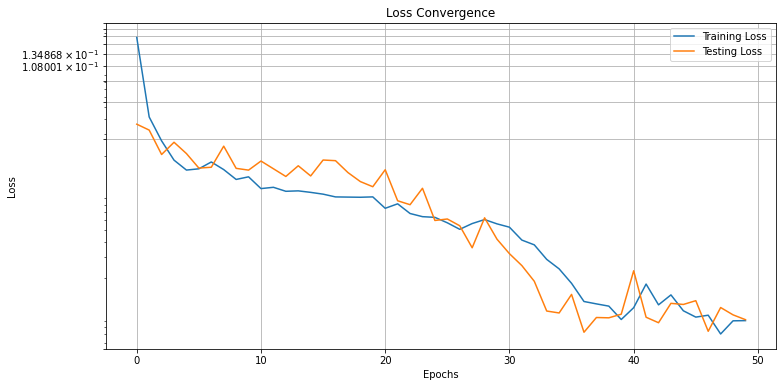

In [59]:
loss_values = np.array(logs)
plot_loss(loss_values[:,0], loss_values[:,1])

In [ ]:
# Test the prediction using rmse

In [62]:
predictions = reg_model(test_dataset.X).squeeze().detach().numpy()
true_values = test_dataset.Y.detach().numpy()
print(f'RMSE: {rmse(predictions, true_values)}')

RMSE: 0.02903495542705059


### Comments
- Using Adam optimizer with a learning rate 0.01 and 30 epochs the loss of the training and evalutation sets decreased to a minimum value.
- The RMSE error for the FFN model is 0.029. We can conclude that the model achieved a comparable performance than least squares (rmse 0.0278) using SGD and FFN to learn to predict the house prices.
- The model could reduce the training error tunning the hyperparameters and adding more complexity to the model.

## 3. Analogies with word vectors.

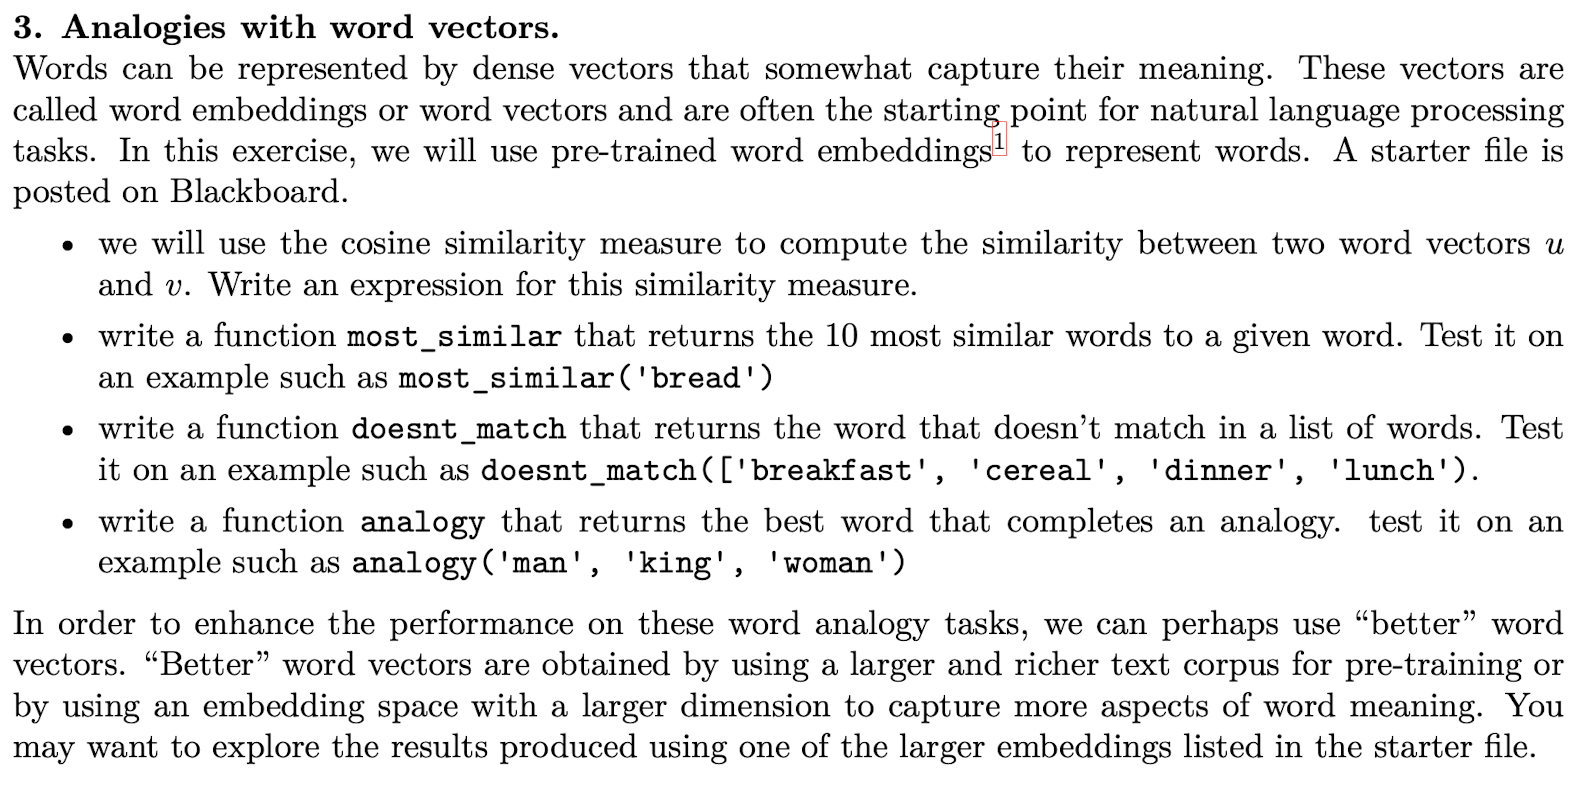

In [2]:
import torch
import torchtext

# download pre-trained word vectors, trained on 6 Billion words, embedding dim 100
vectors = torchtext.vocab.GloVe(name='6B', dim=100, max_vectors=100_000)

# Some other embeddings widely available include:
# (name="42B", dim="300"),
# (name="840B", dim="300"),
# (name="twitter.27B", dim="25"),
# (name="twitter.27B", dim="50"),
# (name="twitter.27B", dim="100"),
# (name="twitter.27B", dim="200"),
# (name="6B", dim="50"),
# (name="6B", dim="100"),
# (name="6B", dim="200"),
# (name="6B", dim="300"),


# Example usage:
u = vectors['bread']    # vector for the word "bread", torch tensor of size (100,)

itos = vectors.itos     # list of the words, mapping indices to words.
stoi = vectors.stoi     # dictionary mapping words to indices.

# to loop over all vectors (in this case 100,000 vectors)
for word in itos:
    if word == 'bread':
        print(word, stoi[word])

bread 5872


In [70]:
class AnalogiesWords:
    def __init__(self, vectors):
        self.vectors = vectors
        self.itos = self.vectors.itos     # list of the words, mapping indices to words.
        self.stoi = self.vectors.stoi     # dictionary mapping words to indices.

    def cosine_similarity(self, u, v):
        # implement the cosine similarity of two vectors
        norm_u = torch.linalg.norm(u)
        norm_v = torch.linalg.norm(v)
        similarity = torch.dot(u,v)/(norm_u*norm_v)
        return similarity.item() 

    def most_similar(self, word, num_words=10):
        # returnt the similar words related to the word
        u = self.vectors[word] # return vector [100]
        similar = np.zeros((len(self.itos),2))
        for word in self.itos:
            v = self.vectors[word]
            idx = self.stoi[word]
            # store the similarities 
            similarity = self.cosine_similarity(u, v)
            similar[idx] = [similarity, idx]
            
        # sort the values based on similarity scores
        sorted_indices = similar[:, 0].argsort()[-num_words:][::-1]
        most_similar_words = [self.itos[int(similar[idx, 1])] for idx in sorted_indices]
        return most_similar_words

    def doesnt_match(self, words):
        embeddings = None
        for word in words:
            # get the word embedding
            if embeddings == None:
                embeddings = self.vectors[word]
            else:
                embeddings = torch.vstack((embeddings,self.vectors[word]))
        mean_embeddings = torch.mean(embeddings, axis=0)
        # get the less similar
        similar = np.zeros((len(words),2))
        for num, word in enumerate(words):
            v = self.vectors[word]
            idx = self.stoi[word]
            similarity = self.cosine_similarity(mean_embeddings, v)
            similar[num] = [similarity, idx]
            
        idx = similar[:, 0].argsort()[0]
        less_similar = self.itos[int(similar[idx, 1])]
        return less_similar

    def analogy(self, base_analogy, goal_word):
        # Compute the embeddings diff of the first two words and add to the third
        u_base = self.vectors[goal_word] + (self.vectors[base_analogy[1]] - self.vectors[base_analogy[0]])
        similar = np.zeros((len(self.itos),2))
        for word in self.itos:
            if word in base_analogy + [goal_word]:  # Skip words in the analogy
                continue
            v = self.vectors[word]
            idx = self.stoi[word]
            # store the similarities 
            similarity = self.cosine_similarity(u_base, v)
            similar[idx] = [similarity, idx]
                
        sorted_similar = sorted(similar, key=lambda x: x[0], reverse=True)
        analogy = self.itos[int(sorted_similar[0][1])]
        return analogy
        

### Most similar words

In [71]:
analogies = AnalogiesWords(vectors)
similar_words = analogies.most_similar('bread')
print(similar_words)

['bread', 'flour', 'baked', 'cake', 'loaf', 'toast', 'cheese', 'potato', 'butter', 'potatoes']


### Doesn't match

In [31]:
less_similar = analogies.doesnt_match(['breakfast', 'cereal', 'dinner', 'lunch'])
print(less_similar)

cereal


### Analogy

In [75]:
analogy = analogies.analogy(['man', 'king'], 'women')
print(analogy)

queen


### Better embeddings

In [79]:
vectors = torchtext.vocab.GloVe(name='6B', dim=300, max_vectors=100_000)
analogies = AnalogiesWords(vectors)
similar_words = analogies.most_similar('bread')
less_similar = analogies.doesnt_match(['breakfast', 'cereal', 'dinner', 'lunch'])
analogy = analogies.analogy(['man', 'king'], 'women')
print(f'Similar words of \'bread\': {similar_words}')
print(f'less similar word of [breakfast, cereal, dinner, lunch]: {less_similar}')
print(f'Analogy of [man, king], \'woman\' : {analogy}')

Similar words of 'bread': ['bread', 'loaf', 'flour', 'butter', 'cheese', 'loaves', 'baked', 'cake', 'crumbs', 'sandwiches']
less similar word of [breakfast, cereal, dinner, lunch]: cereal
Analogy of [man, king], 'woman' : queen


## 4. Sentiment analysis with pre-trained word vectors

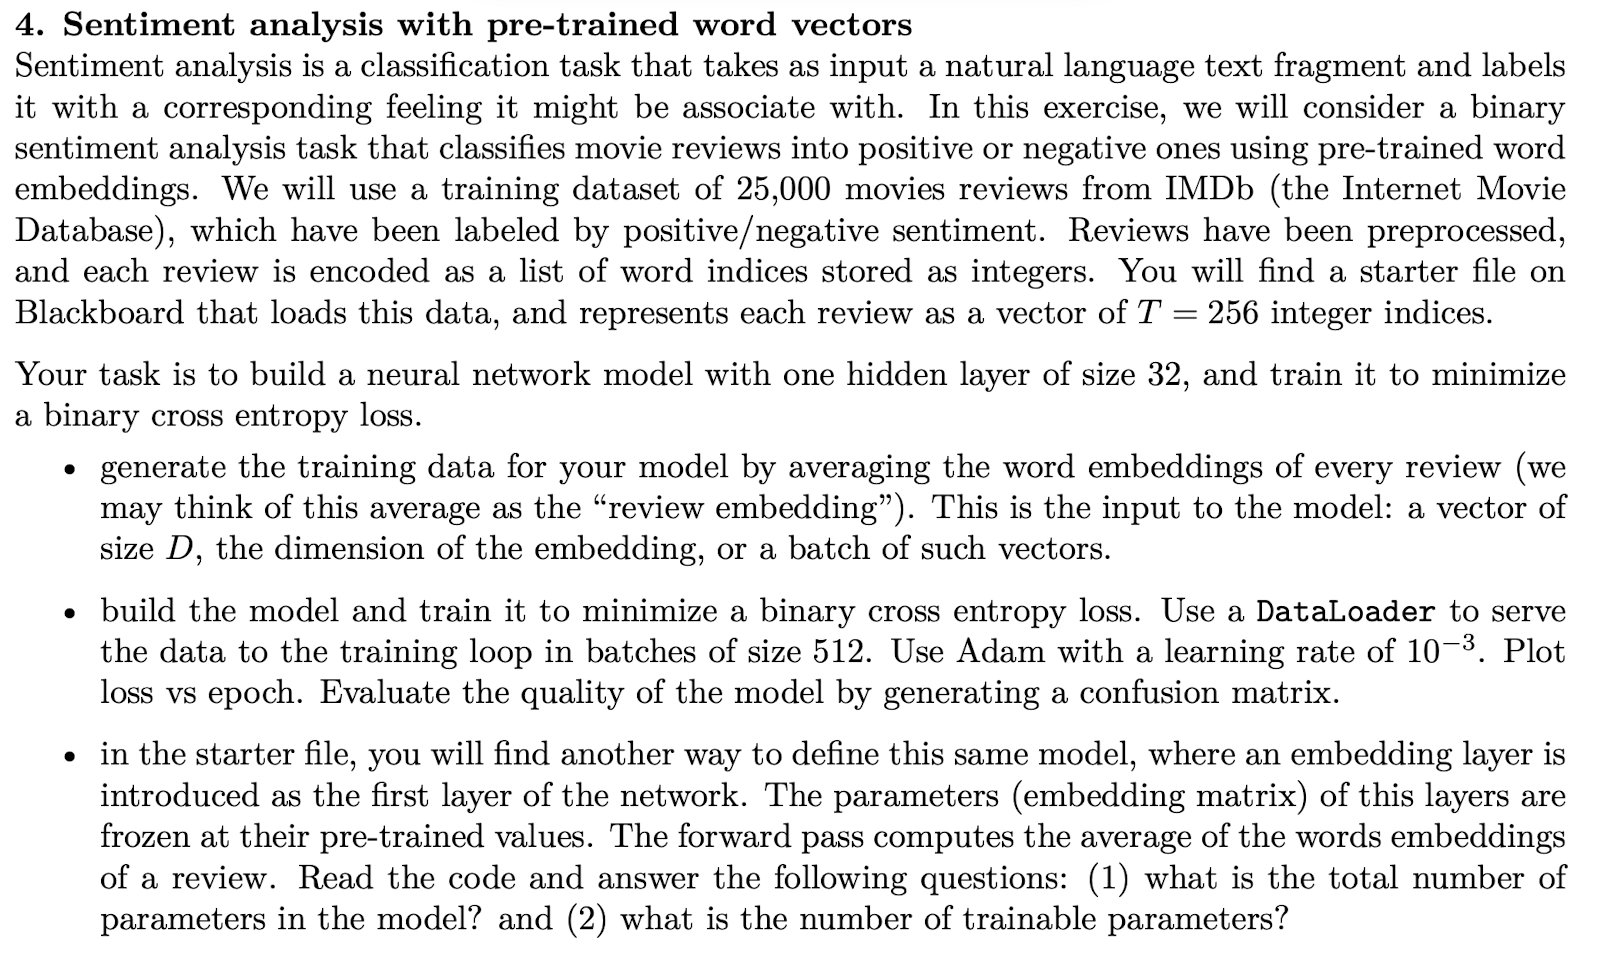

In [26]:
import torch
import torchtext
import torch.nn as nn
import torch.nn.functional as F
from torchtext.datasets import IMDB
from torchtext.data.utils import get_tokenizer
from torch.utils.data import Dataset, TensorDataset, DataLoader
from collections import Counter
from torchinfo import summary

# download or read from cache IMDb data
train_data = list(IMDB(split='train'))
test_data = list(IMDB(split='test'))

In [7]:
# download or read from cache word embeddings
vectors = torchtext.vocab.GloVe(name='6B', dim=50, max_vectors=100_000)

In [86]:
# build the vocabulary---all words in training data
tokenizer = get_tokenizer('basic_english')
counter = Counter()
for (label, line) in train_data:
    counter.update(tokenizer(line))
counter = dict(counter.most_common())    
vocab = torchtext.vocab.vocab(counter, min_freq=10, specials=('<PAD>', '<unk>'))
vocab.set_default_index(vocab['<unk>'])


print("Vocabulary size: ", len(vocab))
print(train_data[0][1])   # print the text of first review


# takes in a review (string), returns a vector of indices (maxlength T)
def text_transform(x, T=256):
    indices = [vocab[token] for token in tokenizer(x)]
    return indices[:256] if len(indices) > T else indices + [0] * (T-len(indices)) 

# takes in the sentiment, returns 1/0 labels (1 for positive review)
def label_transform(x):
    return 1 if x == 2 else 0

# returns X, y tensors from training data
def create_tensors(train_data):
    label_list, text_list = [], []
    for idx, (label, text) in enumerate(train_data):
        label_list.append(label_transform(label))
        processed_text = torch.tensor(text_transform(text))
        text_list.append(processed_text)
    return torch.stack(text_list), torch.tensor(label_list)

X, y = create_tensors(train_data)

# create dataloader. See https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
dataset = TensorDataset(X, y)
train_dataloader = DataLoader(dataset, batch_size=512, shuffle=True)


# build the embedding matrix for our vocabulary, from pretrained word vectors
def build_embedding(vocab, vectors):
    # loop over all vocab indices, for each get token, get embedding (from token), add it to list
    itos = vocab.get_itos()    # List mapping indices to tokens.
    embed_list = [vectors[tok] for tok in itos]
    return torch.stack(embed_list)

W = build_embedding(vocab, vectors)

Vocabulary size:  20437
I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are 

### Generate Training Data

In [41]:
# process test data
X_test, y_test = create_tensors(test_data)

In [32]:
def generate_embeddings(X, W):
    reviews_embeddings = []
    for review in X:
        embeddings = [W[idx] for idx in review]
        # create the review_embedding
        review_embedding = torch.mean(torch.stack(embeddings), dim=0)
        reviews_embeddings.append(review_embedding)
    return torch.stack(reviews_embeddings)

In [52]:
X_train_emb = generate_embeddings(X, W)
X_test_emb = generate_embeddings(X_test, W)

In [61]:
train_data_emb = TensorDataset(X_train_emb, y.float())
test_data_emb = TensorDataset(X_test_emb, y_test.float())
train_emb_dataloader = DataLoader(train_data_emb, batch_size=512, shuffle=True)
test_emb_dataloader = DataLoader(test_data_emb, batch_size=512, shuffle=True)

### Create model

In [80]:
class ModelEmbeddings(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ModelEmbeddings, self).__init__()
        # Create single layer of size 32
        self.h = nn.Sequential(
            nn.Linear(in_channels, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, out_channels),
        )
    def forward(self, x):
        return self.h(x)

### Train

In [81]:
model_emb = ModelEmbeddings(X_train.shape[1], 1)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_emb.parameters(), lr=1e-3)
logs = train(200, model_emb, optimizer, criterion, train_emb_dataloader, test_emb_dataloader)

Epoch: 0, Training Loss Avg: 0.6881, Test Loss: 0.6832
Epoch: 1, Training Loss Avg: 0.6729, Test Loss: 0.6649
Epoch: 2, Training Loss Avg: 0.6514, Test Loss: 0.6458
Epoch: 3, Training Loss Avg: 0.6321, Test Loss: 0.6307
Epoch: 4, Training Loss Avg: 0.6165, Test Loss: 0.6174
Epoch: 5, Training Loss Avg: 0.6030, Test Loss: 0.6084
Epoch: 6, Training Loss Avg: 0.5920, Test Loss: 0.5948
Epoch: 7, Training Loss Avg: 0.5827, Test Loss: 0.5864
Epoch: 8, Training Loss Avg: 0.5738, Test Loss: 0.5782
Epoch: 9, Training Loss Avg: 0.5667, Test Loss: 0.5722
Epoch: 10, Training Loss Avg: 0.5616, Test Loss: 0.5670
Epoch: 11, Training Loss Avg: 0.5563, Test Loss: 0.5631
Epoch: 12, Training Loss Avg: 0.5525, Test Loss: 0.5595
Epoch: 13, Training Loss Avg: 0.5493, Test Loss: 0.5568
Epoch: 14, Training Loss Avg: 0.5467, Test Loss: 0.5549
Epoch: 15, Training Loss Avg: 0.5451, Test Loss: 0.5529
Epoch: 16, Training Loss Avg: 0.5427, Test Loss: 0.5516
Epoch: 17, Training Loss Avg: 0.5421, Test Loss: 0.5504
Ep

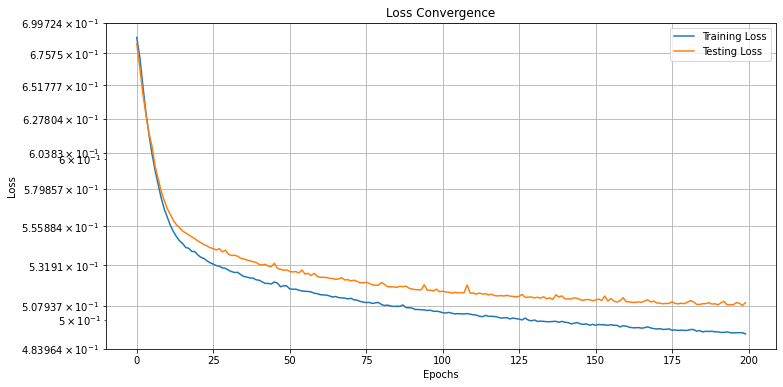

In [82]:
loss_values = np.array(logs)
plot_loss(loss_values[:,0], loss_values[:,1])

### Confusion Matrix

In [83]:
def visualize_confusion_matrix(test_labels, test_predicted_labels, labels=[1,0]):
    print("\nCONFUSSION MATRIX\n")
    conf_matrix = confusion_matrix(test_labels, test_predicted_labels)
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

def visualize_classification_report(test_labels, test_predicted_labels, labels=[1,0]):
    # Generate the test classification report
    print("\nCLASSIFICATION REPORT\n")
    report = classification_report(test_labels, test_predicted_labels, target_names=labels)
    print(report)

In [84]:
model_emb.eval()

with torch.no_grad():
    test_predictions = torch.sigmoid(model_emb(torch.tensor(X_test_emb))).round()

<ipython-input-84-5c0390239478>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_predictions = torch.sigmoid(model_emb(torch.tensor(X_test_emb))).round()



CONFUSSION MATRIX



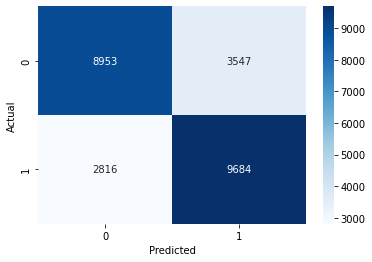


CLASSIFICATION REPORT

              precision    recall  f1-score   support

           0       0.76      0.72      0.74     12500
           1       0.73      0.77      0.75     12500

    accuracy                           0.75     25000
   macro avg       0.75      0.75      0.75     25000
weighted avg       0.75      0.75      0.75     25000



In [85]:
visualize_confusion_matrix(y_test, test_predictions, labels=['0','1'])
visualize_classification_report(y_test, test_predictions, labels=['0','1'])

### Alternative Model

In [87]:
# define the neural network
class MLP(nn.Module):
  def __init__(self):
    super(MLP, self).__init__()
    self.embed = nn.Embedding.from_pretrained(W)  # define params of embedding layer
    self.embed.weight.requires_grad = False       # freeze params, default
    self.linear1 = nn.Linear(W.shape[1], 32)      # define layer 1 parameters
    self.linear2 = nn.Linear(32, 1)               # define layer 2 parameters

  def forward(self, x):
    rdim = 0 if x.ndim == 1 else 1   # if x is a batch, reduction is along dim 1
    x = x.to(torch.long)             # change type (to get around bug in summary!)
    x = self.embed(x)                # returns tensor of shape (*, T, D)
    x = torch.mean(x, dim=rdim)      # average the embeddings
    x = self.linear1(x)              # first linear layer
    x = F.relu(x)                    # nonlinear activation, try tanh perhaps? 
    x = self.linear2(x)              # output logit
    return x
  
model = MLP()

summary(model, input_size=([10, 256,]))

Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [10, 1]                   --
├─Embedding: 1-1                         [10, 256, 50]             (1,021,850)
├─Linear: 1-2                            [10, 32]                  1,632
├─Linear: 1-3                            [10, 1]                   33
Total params: 1,023,515
Trainable params: 1,665
Non-trainable params: 1,021,850
Total mult-adds (M): 10.24
Input size (MB): 0.01
Forward/backward pass size (MB): 1.03
Params size (MB): 4.09
Estimated Total Size (MB): 5.13

**What is the total number of parameters in the model?**

    - The total parameters are: 1,023,515. Correspond to the embedding layer and the linear layers
    
**How many of these parameters are trainable (i.e., not frozen)?**

    - The trainable parameters are 1,665.
    - Non-trainable parameters: 1,021,850

The model is adding the embedding layer from pytorch that is pretrained. This layer is frozen to only train the linear layers. In the forward part is computed the embedding and with the torch.mean is computed the review embedding, to then being passed to the linear layers.

## 5. Sentiment analysis with trainable embeddings

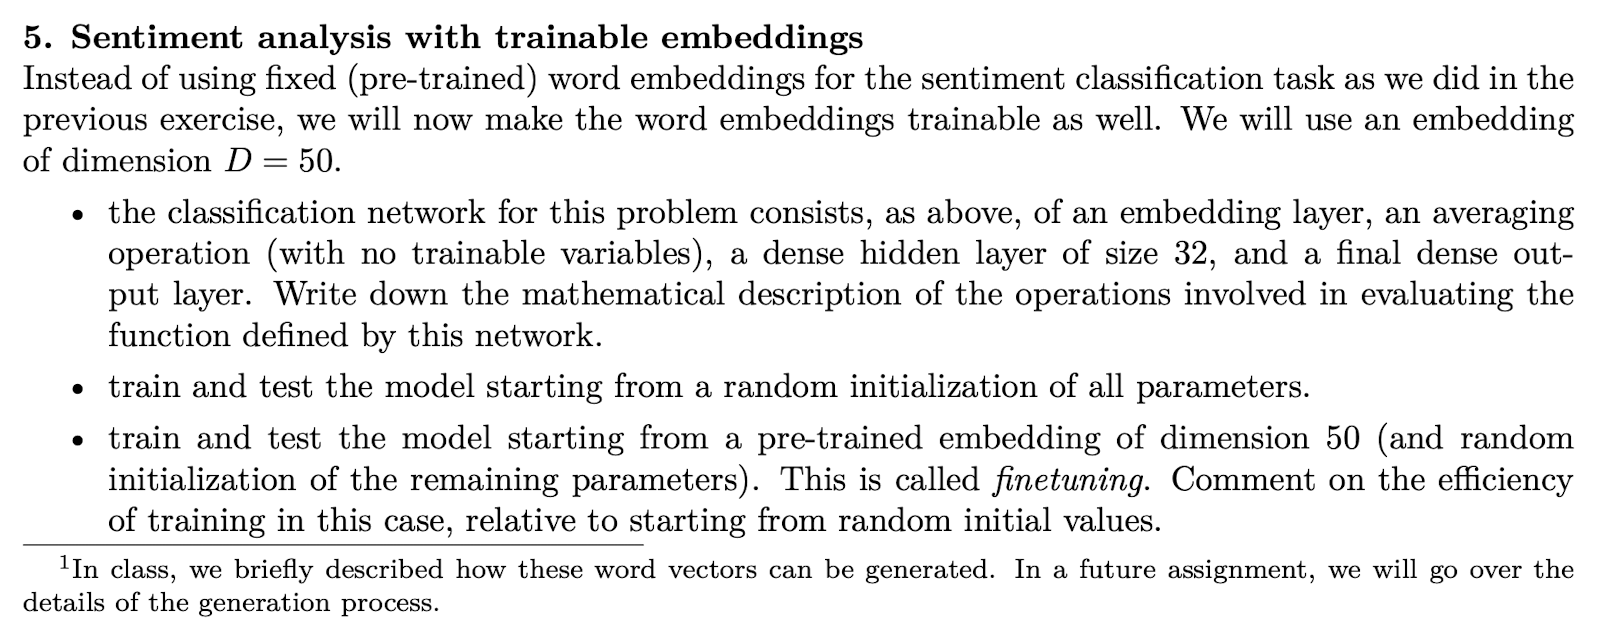

In [141]:
class MLP(nn.Module):
    def __init__(self, emb_dim, vocab_size=None, pretrained_weights=None):
        super(MLP, self).__init__()
        if pretrained_weights is not None:
            print('using pretrained embedding layer')
            self.embed = nn.Embedding.from_pretrained(pretrained_weights)
            self.embed.weight.requires_grad = False
        else:
            self.embed = nn.Embedding(vocab_size, emb_dim)
            self.embed.weight.requires_grad = True
        self.linear1 = nn.Linear(50, 32)             
        self.linear2 = nn.Linear(32, 1)
        
    def forward(self, x):
        rdim = 0 if x.ndim ==1 else 1
        x = x.to(torch.long)
        x = self.embed(x)                # returns tensor of shape (*, T, D)
        x = torch.mean(x, dim=rdim)      # average the embeddings
        x = self.linear1(x)              # first linear layer
        x = F.relu(x)                    # nonlinear activation, try tanh perhaps? 
        x = self.linear2(x)  
        return x

### No pretrained embedding layer weights

In [142]:
dim = 50
vocab_size = len(vocab)
model_np = MLP(dim, vocab_size)
# criterion and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_np.parameters(), lr=1e-3)
# generate datasets
train_dataset = TensorDataset(X, y.float())
test_dataset = TensorDataset(X_test, y_test.float())
# generate dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=True)
# Train for 20 epochs
logs = train(20, model_np, optimizer, criterion, train_dataloader, test_dataloader)

Epoch: 0, Training Loss Avg: 0.6921, Test Loss: 0.6895
Epoch: 1, Training Loss Avg: 0.6818, Test Loss: 0.6711
Epoch: 2, Training Loss Avg: 0.6429, Test Loss: 0.6194
Epoch: 3, Training Loss Avg: 0.5672, Test Loss: 0.5509
Epoch: 4, Training Loss Avg: 0.4859, Test Loss: 0.4912
Epoch: 5, Training Loss Avg: 0.4191, Test Loss: 0.4460
Epoch: 6, Training Loss Avg: 0.3687, Test Loss: 0.4147
Epoch: 7, Training Loss Avg: 0.3310, Test Loss: 0.3948
Epoch: 8, Training Loss Avg: 0.3016, Test Loss: 0.3745
Epoch: 9, Training Loss Avg: 0.2788, Test Loss: 0.3651
Epoch: 10, Training Loss Avg: 0.2571, Test Loss: 0.3554
Epoch: 11, Training Loss Avg: 0.2400, Test Loss: 0.3507
Epoch: 12, Training Loss Avg: 0.2245, Test Loss: 0.3505
Epoch: 13, Training Loss Avg: 0.2103, Test Loss: 0.3452
Epoch: 14, Training Loss Avg: 0.1975, Test Loss: 0.3457
Epoch: 15, Training Loss Avg: 0.1861, Test Loss: 0.3452
Epoch: 16, Training Loss Avg: 0.1750, Test Loss: 0.3418
Epoch: 17, Training Loss Avg: 0.1659, Test Loss: 0.3483
Ep

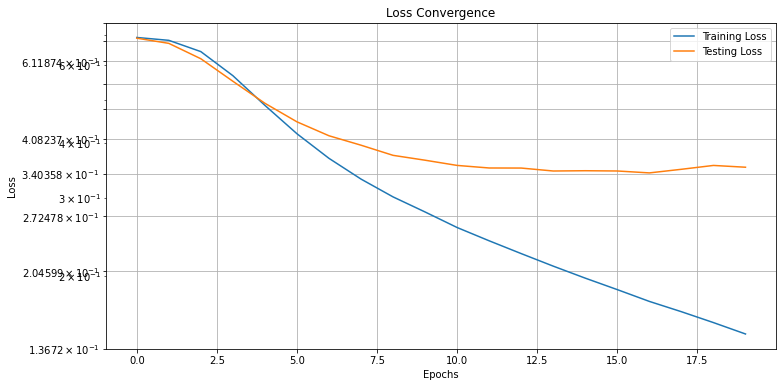

In [143]:
loss_values = np.array(logs)
plot_loss(loss_values[:,0], loss_values[:,1])

<ipython-input-144-addb5abed204>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_predictions = torch.sigmoid(model_np(torch.tensor(X_test))).round()



CONFUSSION MATRIX



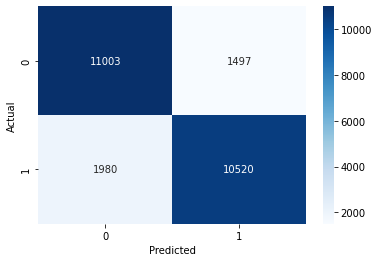


CLASSIFICATION REPORT

              precision    recall  f1-score   support

           0       0.85      0.88      0.86     12500
           1       0.88      0.84      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



In [144]:
model_np.eval()

with torch.no_grad():
    test_predictions = torch.sigmoid(model_np(torch.tensor(X_test))).round()

visualize_confusion_matrix(y_test, test_predictions, labels=['0','1'])
visualize_classification_report(y_test, test_predictions, labels=['0','1'])

### Pretrained embedding layer

In [146]:
model_pre = MLP(dim, vocab_size, W)
# criterion and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_pre.parameters(), lr=1e-3)
logs = train(5, model_pre, optimizer, criterion, train_dataloader, test_dataloader)

using pretrained embedding layer
Epoch: 0, Training Loss Avg: 0.6572, Test Loss: 0.6338
Epoch: 1, Training Loss Avg: 0.5475, Test Loss: 0.5321
Epoch: 2, Training Loss Avg: 0.4028, Test Loss: 0.4369
Epoch: 3, Training Loss Avg: 0.2858, Test Loss: 0.3769
Epoch: 4, Training Loss Avg: 0.2060, Test Loss: 0.3470


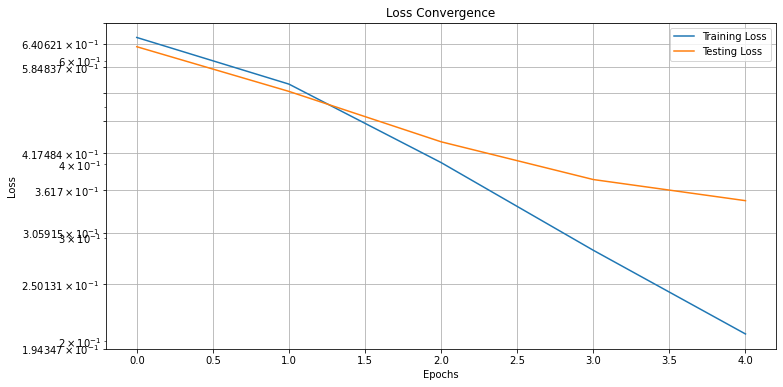

In [147]:
loss_values = np.array(logs)
plot_loss(loss_values[:,0], loss_values[:,1])

<ipython-input-148-2a1f3336cd3c>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_predictions = torch.sigmoid(model_pre(torch.tensor(X_test))).round()



CONFUSSION MATRIX



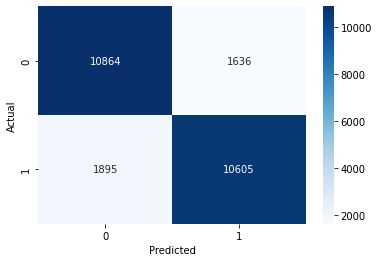


CLASSIFICATION REPORT

              precision    recall  f1-score   support

           0       0.85      0.87      0.86     12500
           1       0.87      0.85      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



In [148]:
model_pre.eval()

with torch.no_grad():
    test_predictions = torch.sigmoid(model_pre(torch.tensor(X_test))).round()

visualize_confusion_matrix(y_test, test_predictions, labels=['0','1'])
visualize_classification_report(y_test, test_predictions, labels=['0','1'])

### Comments
- Without using the pretrained weights the training takes 4 times the training of using pretrained weights with the embeddings W.
- After the training the model with pretrained weights has comparable and better performance than the model without pretrained weights.